In [2]:
import numpy as np
import scipy.optimize as opt
import numba
import pylab
from scipy import stats
import matplotlib.pyplot as plt
import ar1_approx as ar1
from LinApp_FindSS import LinApp_FindSS
from LinApp_Deriv import LinApp_Deriv
from LinApp_Solve import LinApp_Solve
from collections import namedtuple
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# exercise 1


In [3]:
# set parameters
alpha = .35
beta = .98
rho = 0.95
sigma = 0.02
params = [alpha, beta, rho, sigma]
Zbar = np.array([0.])
nk = 1
nz = 1


In [4]:
def Modeldyn(theta0, params):
    '''
    Inputs:
        theta: a vector containng (Kpp, Kp, K, Zp, Z) where:
            Kpp: value of capital in two periods
            Kp: value of capital in next period
            K: value of capital this period
            Zp: value of productivity in next period
            Z: value of productivity this period
        params: list of parameter values
    
    Output:
        a function obtained from Euler equation so that the output is zero at the
            steady state values of X, Y & Z.  
    '''
    (Kpp, Kp, K, Zp, Z) = theta0
    
    E = 1/(np.exp(Z) * K ** alpha - Kp) - beta * ((alpha * np.exp(Zp) * Kp ** (alpha - 1))/ 
                                             (np.exp(Zp) * Kp ** alpha - Kpp))
                                                                            
    return E

In [5]:
# take a initial guess for steady state values of k and ell
guess_k = np.array([.25])

# find the steady state values using LinApp_FindSS
kbar = LinApp_FindSS(Modeldyn, params, guess_k, Zbar, nk, 0)[0]

# set up steady state input vector
theta0 = np.array([kbar, kbar, kbar, 0., 0.])

# check SS solution
error = Modeldyn(theta0, params)
if np.abs(error) > 1.E-6:
    raise ValueError ("SS solution is incorrect")

In [6]:
# find parameter matrics 
[A, B, C, D, F, G, H, J, K, L, M, W, T] = LinApp_Deriv(Modeldyn, params, theta0, nk, 0, nz, logX=False)
N = np.array([rho])


In [7]:
# define grids for states variables 
k_lb = 0.5 * kbar
k_ub = 1.5 * kbar
kgrid = np.linspace(k_lb, k_ub, 25)
sizek = len(kgrid)
step = 10 * sigma/25
pi, zgrid = ar1.rouwen(rho, 0, step, 25)
sizez = len(zgrid)

In [8]:
# find policy function 
P, Q, U, R, S, V = LinApp_Solve(A,B,C,D,F,G,H,J,K,L,M,W,T,N,Zbar,Sylv=0)
optK1 = np.zeros((sizek, sizez))
for i in range(sizek):
    optK1[i,:] =  (P[0] * (kgrid[i] - kbar) + Q[0] * (zgrid - 0)) + kbar

Text(0.5,0,'Policy Function')

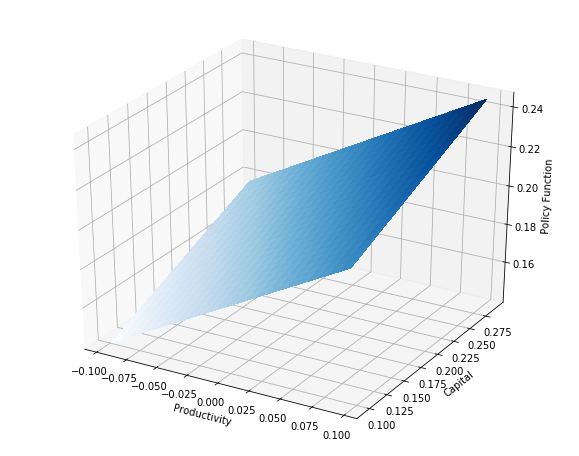

In [14]:
fig = plt.figure(figsize=(10, 8))
zmat, kmat = np.meshgrid(kgrid, zgrid)
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(kmat, zmat, optK1, rstride=1, cstride=1, cmap=cm.Blues,
                linewidth=0, antialiased=False)
#ax.view_init(elev=20., azim=20)  #rotate for better view 
ax.set_xlabel(r'Productivity')
ax.set_ylabel(r'Capital')
ax.set_zlabel(r'Policy Function')

Text(0.5,0,'Policy Function')

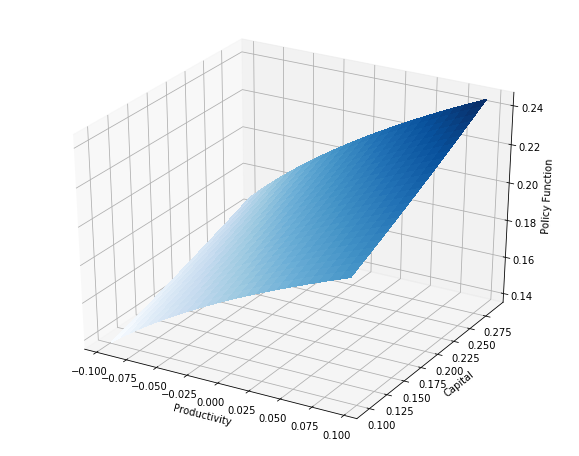

In [15]:
optK2 = np.zeros((sizek, sizez))
for i in range(sizek):
    for j in range(sizez):
        optK2[i, j] = alpha * beta * kgrid[i] ** alpha * np.exp(zgrid[j])

fig = plt.figure(figsize=(10, 8))
zmat, kmat = np.meshgrid(kgrid, zgrid)
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(kmat, zmat, optK2, rstride=1, cstride=1, cmap=cm.Blues,
                linewidth=0, antialiased=False)
#ax.view_init(elev=20., azim=20)  # to rotate plot for better view
ax.set_xlabel(r'Productivity')
ax.set_ylabel(r'Capital')
ax.set_zlabel(r'Policy Function')

two plots look similar 

# exercise 2

In [10]:
# find parameter matrics 
[A, B, C, D, F, G, H, J, K, L, M, W, T] = LinApp_Deriv(Modeldyn, params, theta0, nk, 0, nz, logX=True)
N = np.array([rho])

In [11]:
# define grids for states variables 
k_lb = 0.5 * kbar
k_ub = 1.5 * kbar
kgrid = np.linspace(k_lb, k_ub, 25)
sizek = len(kgrid)
step = 10 * sigma/25
pi, zgrid = ar1.rouwen(rho, 0, step, 25)
sizez = len(zgrid)

In [12]:
# find policy function 
P, Q, U, R, S, V = LinApp_Solve(A,B,C,D,F,G,H,J,K,L,M,W,T,N,Zbar,Sylv=1)
optK3 = np.zeros((sizek, sizez))
for i in range(sizek):
    for j in range(sizez):
        optK3[i,j] =  (P[0] * ((kgrid[i] - kbar) / kbar) + Q[0] * zgrid[j]) * kbar + kbar

Using Sylvester equation solver...


Text(0.5,0,'Policy Function')

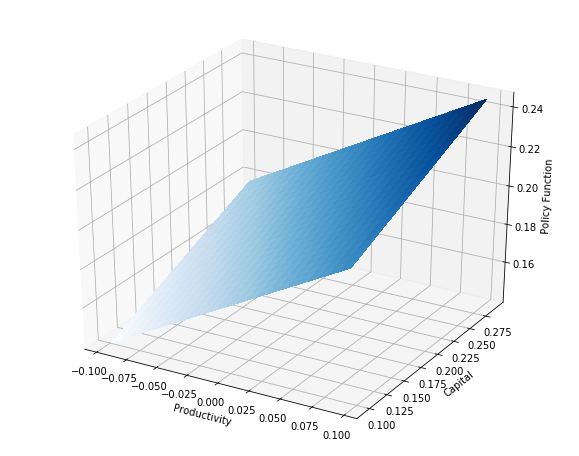

In [20]:
fig = plt.figure(figsize=(10, 8))
zmat, kmat = np.meshgrid(kgrid, zgrid)
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(kmat, zmat, optK3, rstride=1, cstride=1, cmap=cm.Blues,
                linewidth=0, antialiased=False)

#ax.view_init(elev=20., azim=20)  # to rotate plot for better view
ax.set_xlabel(r'Productivity')
ax.set_ylabel(r'Capital')
ax.set_zlabel(r'Policy Function')

# exercise 3


$$\begin{align*}
        F(P^2\tilde{X}_{t-1}+(NQ+Q)\tilde{Z}_t)+G(P\tilde{X}_{t-1}+Q\tilde{Z}_t)+H\tilde{X}_{t-1}+LN\tilde{Z}_t+M\tilde{Z}_t = 0.\\
        [(FP+Q)P+H]\tilde{X}_{t-1}+[(FQ+L)N+(FP+G)Q+M]\tilde{Z}_t =0
\end{align*}$$

# exercise 4


In [13]:
#parameters
gamma = 2.5
xi = 1.5
beta = 0.98
alpha = 0.4
a = 0.5
delta = 0.10
tau = 0.05
rho = 0.9
params = (gamma, xi, beta, alpha, a, delta, tau)
Zbar = np.array([0.])
nx = 1
ny = 1
nz = 1
# take an initial guess for k and l
guessXY = np.array([2, .45])



In [14]:
#using characteristic eqs 
def get_c(w, r, kp, k, l):
    c = w * l + (r - delta) * k + k - kp
    return c

def get_r(k, l, z):
    r = alpha * (l/k) ** (1 - alpha) * (np.exp(z)) ** (1 - alpha)
    return r

def get_w(k, l, z):
    w = (1 - alpha) * (k/l) ** alpha * (np.exp(z)) ** (1 - alpha)
    return w

In [15]:
def error(theta0, params):
    (Xpp, Xp, X, Yp, Y, Zp, Z) = theta0
    w = get_w(X, Y, Z)
    wp = get_w(Xp, Yp, Zp)
    r = get_r(X, Y, Z)
    rp = get_r(Xp, Yp, Zp)
    c = get_c(w, r, Xp, X, Y)
    cp = get_c(wp, rp, Xpp, Xp, Yp)
    # Evaluate errors 
    E1 = a * (1 - Y) ** (-xi) - (c ** (-gamma) * w * (1 - tau)) 
    E2 = c ** (-gamma)  - beta * (cp ** (-gamma)* ((1 - tau) * (rp - delta) + 1))
    return np.array([E1, E2])

In [16]:
# find the steady state values 
XYbar = LinApp_FindSS(error, params, guessXY, Zbar, nx, ny)
(kbar, lbar) = XYbar
print("steady state k is: ",kbar)
print("steady state l is: ",lbar)


steady state k is:  4.225229026788538
steady state l is:  0.579791453167062


# exercise 5


In [17]:
# to calculate derivatives, add a small value to each variable and calculate the slope
e = 1.001
e1 = e - 1
k=kbar
l=lbar

In [44]:
def get_cbar(w, r, k, l):
    c_bar = w * l + (r - delta) * k
    return c_bar

def get_rbar(k, l):
    r_bar = alpha * (l/k) ** (1 - alpha) * (np.exp(Zbar)) ** (1 - alpha)
    return r_bar

def get_wbar(k, l):
    w_bar = (1 - alpha) * (k/l) ** alpha * (np.exp(Zbar)) ** (1 - alpha)
    return w_bar
def get_Tbar(w, r, k, l):
    T_bar = tau * (w * l + (r - delta) * k)
    return T_bar

def get_ibar(k):
    i_bar = delta * k
    return i_bar

def get_ybar(k, l):
    y_bar = k ** alpha * l ** (1 - alpha)
    return y_bar


In [ ]:
delta *= e
#solve for new state variables using the method defined in the last problem set 
args2 = (gamma, xi, beta, alpha, a, delta, tau, Zbar)
k, l = opt.fsolve(euler, np.array([1, 0.8]), args = (args2))
w = get_wbar(k, l)
r = get_rbar(k, l)
c = get_cbar(w, r, k, l)
T = get_Tbar(w, r, k, l)
i = get_ibar(k)
y = get_ybar(k, l)
#k2,l2,w2,rs,c2,T2,i2,y2 represent the original variables solved in the last problem set
print('dk/d(delta): '+str((k-k2)/(delta/e * e1)))
print('dl/d(delta): '+str((l-l2)/(delta/e * e1)))
print('dw/d(delta): '+str((w-w2)/(delta/e * e1)))
print('dr/d(delta): '+str((r-r2)/(delta/e * e1)))
print('dc/d(delta): '+str((c-c2)/(delta/e * e1)))
print('dT/d(delta): '+str((T-T2)/(delta/e * e1)))
print('di/d(delta): '+str((i-i2)/(delta/e * e1)))
print('dy/d(delta): '+str((y-y2)/(delta/e * e1)))
#restore the original value og delta 
delta /= e
#we can use this method to calculate all the partical derivatives 

# exercise 6


In [31]:
def Modeldyn(theta0, params):
    (Xpp, Ypp, Xp, Yp, X, Y, Zp, Z) = theta0
    w = get_w(X, Yp, Z)
    wp = get_w(Xp, Ypp, Zp)
    r = get_r(X, Yp, Z)
    rp = get_r(Xp, Ypp, Zp)
    c = get_c(w, r, Xp, X, Yp)
    cp = get_c(wp, rp, Xpp, Xp, Ypp)
    # Evaluate errors
    E1 = a * (1 - Yp) ** (-xi)  - (c ** (-gamma) * w * (1 - tau))
    E2 = c ** (-gamma) - ( beta * (cp ** (-gamma)* ((1 - tau) * (rp - delta) + 1))) 
    
    return np.array([E1, E2])

In [32]:
Zbar = np.array([0.])
nx = 2
ny = 0
nz = 1
params = (gamma, xi, beta, alpha, a, delta, tau)

In [33]:
# take a guess for steady state values of k and ell
guessXY = np.array([2, .25])

# find the steady state values using LinApp_FindSS
XYbar = LinApp_FindSS(Modeldyn, params, guessXY, Zbar, nx, ny)
(kbar, lbar) = XYbar


# set up steady state input vector
theta0 = np.array([kbar, lbar, kbar, lbar, kbar, lbar, 0., 0.])



In [35]:

# find the parameter matrices
[A, B, C, D, F, G, H, J, K, L, M, W, T] = LinApp_Deriv(Modeldyn, params, theta0, nx, ny, nz, logX=True)

N= rho
    
# find P and Q
P, Q, U, R, S, V = LinApp_Solve(A,B,C,D,F,G,H,J,K,L,M,W,T,N,Zbar,Sylv=0)
print ('P:',P)
print ('Q', Q)

P: [[ 0.9152937   0.        ]
 [-0.19192697  0.        ]]
Q [[ 0.1289971 ]
 [-0.01131015]]


# exercise 7


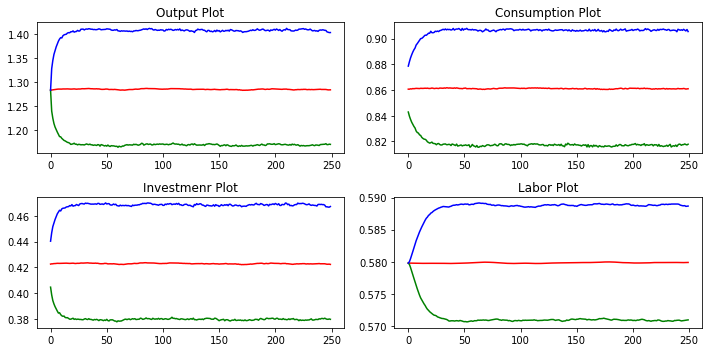

In [38]:
#generate time series  
sigmaz = 0.02
e = np.random.normal(0, scale=sigmaz, size=(10000, 251))

z = np.zeros_like(e)
z[:, 0] = np.zeros(10000)
for i in range(1, 251):
    z[:, i] = rho * z[:, i - 1] + e[:, i]
k = np.zeros_like(e)
l = np.zeros_like(e)
c = np.zeros_like(e)
y = np.zeros_like(e)
I = np.zeros_like(e)

for i in range(1, 251):
    k[:, i] = P[0, 0] * k[:, i - 1] + Q[0, 0] * z[:, i] 
    l[:, i] = P[1, 0] * k[:, i - 1] + Q[1, 0] * z[:, i]
k = kbar * np.exp(k)
l = lbar * np.exp(l)

w = get_w(k, l, z)
r = get_r(k, l, z)

for i in range(250):
    y[:, i] = k[:, i] ** alpha * l[:, i] ** (1 - alpha) * np.exp(z[:, i])
    I[:, i] = k[:, i + 1] - (1 - delta) * k[:, i]
    c[:, i] = w[:, i] * l[:, i] + (r[:, i] - delta) * k[:, i] + k[:, i] - k[:, i+1]
y = y[:, 0:250]
I = I[:, 0:250]
c = c[:, 0:250]
l = l[:, 0:250]
ymean = y.mean(axis=0)
cmean = c.mean(axis=0)
Imean = I.mean(axis=0)
lmean = l.mean(axis=0)
ymin = np.zeros(250)
ymax = np.zeros(250)
cmin = np.zeros(250)
cmax = np.zeros(250)
Imin = np.zeros(250)
Imax = np.zeros(250)
lmin = np.zeros(250)
lmax = np.zeros(250)
for i in range(250):
    ymin[i] = np.percentile(y[:, i], 5)
    ymax[i] = np.percentile(y[:, i], 95)
    cmin[i] = np.percentile(c[:, i], 5)
    cmax[i] = np.percentile(c[:, i], 95)
    Imin[i] = np.percentile(I[:, i], 5)
    Imax[i] = np.percentile(I[:, i], 95)
    lmin[i] = np.percentile(l[:, i], 5)
    lmax[i] = np.percentile(l[:, i], 95)
plt.subplot(221)
plt.plot(np.arange(0, 250), ymean[0: 250], c='r')
plt.plot(np.arange(0, 250), ymin, c ='g')
plt.plot(np.arange(0, 250), ymax, c ='b')
plt.title("Output Plot")
plt.subplot(222)
plt.plot(np.arange(0, 250), cmean[0: 250], c='r')
plt.plot(np.arange(0, 250), cmin, c ='g')
plt.plot(np.arange(0, 250), cmax, c ='b')
plt.title("Consumption Plot")
plt.subplot(223)
plt.plot(np.arange(0, 250), Imean[0: 250], c='r')
plt.plot(np.arange(0, 250), Imin, c ='g')
plt.plot(np.arange(0, 250), Imax, c ='b')
plt.title("Investmenr Plot")
plt.subplot(224)
plt.plot(np.arange(0, 250), lmean[0: 250], c='r')
plt.plot(np.arange(0, 250), lmin, c ='g')
plt.plot(np.arange(0, 250), lmax, c ='b')
plt.title("Labor Plot")
plt.tight_layout()
plt.show()


# exercise 8

In [39]:
ymean1 = y.mean(axis=1).mean()
cmean1 = c.mean(axis=1).mean()
Imean1 = I.mean(axis=1).mean()
lmean1 = l.mean(axis=1).mean()

ystd1 = y.std(axis=1).mean()
cstd1 = c.std(axis=1).mean()
Istd1 = I.std(axis=1).mean()
lstd1 = l.std(axis=1).mean()

ycv1 = (y.mean(axis=1)/y.std(axis=1)).mean()
ccv1 = (c.mean(axis=1)/c.std(axis=1)).mean()
Icv1 = (I.mean(axis=1)/I.std(axis=1)).mean()
lcv1 = (l.mean(axis=1)/l.std(axis=1)).mean()

crv1 = (c.std(axis=1)/y.std(axis=1)).mean()
Irv1 = (I.std(axis=1)/y.std(axis=1)).mean()
lrv1 = (l.std(axis=1)/y.std(axis=1)).mean()

ymean2 = stats.sem(y.mean(axis=1))
cmean2 = stats.sem(c.mean(axis=1))
Imean2 = stats.sem(I.mean(axis=1))
lmean2 = stats.sem(l.mean(axis=1))

ystd2 = stats.sem(y.std(axis=1))
cstd2 = stats.sem(c.std(axis=1))
Istd2 = stats.sem(I.std(axis=1))
lstd2 = stats.sem(l.std(axis=1))

ycv2 = stats.sem((y.mean(axis=1)/y.std(axis=1)))
ccv2 = stats.sem((c.mean(axis=1)/c.std(axis=1)))
Icv2 = stats.sem((I.mean(axis=1)/I.std(axis=1)))
lcv2 = stats.sem((l.mean(axis=1)/l.std(axis=1)))

crv2 = stats.sem((c.std(axis=1)/y.std(axis=1)))
Irv2 = stats.sem((I.std(axis=1)/y.std(axis=1)))
lrv2 = stats.sem((l.std(axis=1)/y.std(axis=1)))

yp = np.zeros(10000-1)
cp = np.zeros(10000-1)
Ip = np.zeros(10000-1)
lp = np.zeros(10000-1)

cc = np.zeros(10000)
Ic = np.zeros(10000)
lc = np.zeros(10000)
    
for i in range(10000):
    cc[i] = np.corrcoef(y[i, :], c[i, :])[0, 1]
    Ic[i] = np.corrcoef(y[i, :], I[i, :])[0, 1]
    lc[i] = np.corrcoef(y[i, :], l[i, :])[0, 1]

cc1 = cc.mean()
Ic1 = Ic.mean()
lc1 = lc.mean()
cc2 = stats.sem(cc)
Ic2 = stats.sem(Ic)
lc2 = stats.sem(lc)

for i in range(10000-1):
    yp[i] = np.corrcoef(y[i, :-1], y[i, 1:])[0, 1] 
    cp[i] = np.corrcoef(y[i, :-1], c[i, 1:])[0, 1] 
    Ip[i] = np.corrcoef(y[i, :-1], I[i, 1:])[0, 1] 
    lp[i] = np.corrcoef(y[i, :-1], l[i, 1:])[0, 1] 

yp1 = yp.mean()
cp1 = cp.mean()
Ip1 = Ip.mean()
lp1 = lp.mean()
yp2 = stats.sem(yp)
cp2 = stats.sem(cp)
Ip2 = stats.sem(Ip)
lp2 = stats.sem(lp)

In [41]:
print("In the order of GDP, Consumption, Investment, Labor")
print(str(ymean1)+"  "+str(ymean2))
print(str(cmean1)+"  "+str(cmean2))
print(str(Imean1)+"  "+str(Imean2))
print(str(lmean1)+"  "+str(lmean2))
print("")
print("volatility")
print(str(ystd1)+"  "+str(ystd2))
print(str(cstd1)+"  "+str(cstd2))
print(str(Istd1)+"  "+str(Istd2))
print(str(lstd1)+"  "+str(lstd2))
print("")
print("Coefficient of Variation")
print(str(ycv1)+"  "+str(ycv2))
print(str(ccv1)+"  "+str(ccv2))
print(str(Icv1)+"  "+str(Icv2))
print(str(lcv1)+"  "+str(lcv2))
print("")
print("Relative volatility")
print(str(crv1)+"  "+str(crv2))
print(str(Irv1)+"  "+str(Irv2))
print(str(lrv1)+"  "+str(lrv2))
print("")
print("Persistence")
print(str(yp1)+"  "+str(yp2))
print(str(cp1)+"  "+str(cp2))
print(str(Ip1)+"  "+str(Ip2))
print(str(lp1)+"  "+str(lp2))
print("")
print("Cyclicality")
print(str(cc1)+"  "+str(cc2))
print(str(Ic1)+"  "+str(Ic2))
print(str(lc1)+"  "+str(lc2))

In the order of GDP, Consumption, Investment, Labor
1.2850888907382636  0.0002235331838035682
0.8611160430111043  8.127412733446622e-05
0.42294082264090155  7.897699905189197e-05
0.5798242871766721  2.1012556759063242e-05

volatility
0.06696760433157811  0.00010732812590950956
0.025290197459617147  3.433468429125722e-05
0.02538348296232294  3.7881706986555344e-05
0.004729162629929719  1.0915362750316474e-05

Coefficient of Variation
19.672429991097786  0.031057051595291662
34.65422522815631  0.04541857501662612
17.0240609240057  0.024984981760288735
129.40344190185414  0.31073024145165246

Relative volatility
0.37926739205726645  0.00013080878893744746
0.3797163055019279  5.7677460111762245e-05
0.0699365446358631  6.392448623892326e-05

Persistence
0.9106089427051753  0.0002816098021414999
0.8351256844665538  0.0004313227523612704
0.8007665103290831  0.0005534511761077427
-0.8026760505945553  0.00046040106631530897

Cyclicality
0.8709362303288497  0.00027750047240139743
0.8938340781900

# exercise 9


In [44]:
# shock=[z, k, l, y, i, c]
shock = np.zeros((6, 41))

k = np.zeros_like(41)
shock[0, 0]=0
shock[1, 0]=0
shock[2, 0]=0

for i in range(1, 41):
    shock[0, i] = rho ** i * sigmaz
    shock[1, i] = P[0, 0] * shock[1, i - 1] + Q[0, 0] * shock[0, i] 
    shock[2, i] = P[1, 0] * shock[1, i - 1] + Q[1, 0] * shock[0, i] 
shock[1, :] = kbar * np.exp(shock[1, :])
shock[2, :] = lbar * np.exp(shock[2, :])

w = get_w(shock[1, :], shock[2, :], shock[0, :])
r = get_r(shock[1, :], shock[2, :], shock[0, :])
#generate shocks for l,y,i,c
for i in range(40):
    shock[3, i] = shock[1, i] ** alpha * shock[1, i] ** (1 - alpha)
    shock[4, i] = shock[1, i + 1] - (1 - delta) * shock[1, i]
    shock[5, i] = w[i] * shock[2, i] + (r[i] - delta) * shock[1, i] + shock[1, i] - shock[1, i+1]

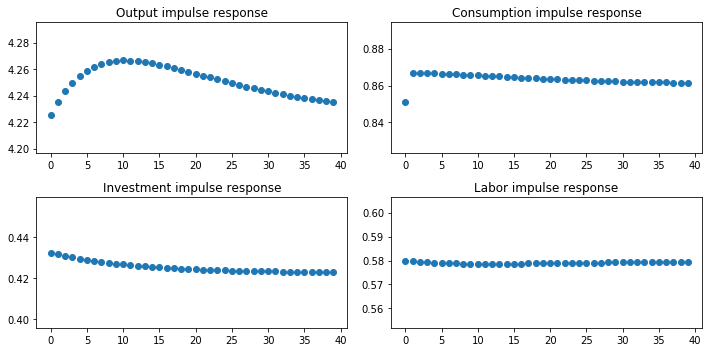

In [47]:
# Plot
pylab.rcParams['figure.figsize'] = (10, 5)
plt.subplot(221)
plt.scatter(np.arange(0, 40), shock[3, :][0: 40])
plt.title("Output impulse response")
plt.subplot(222)
plt.scatter(np.arange(0, 40), shock[5, :][0: 40])
plt.title("Consumption impulse response")
plt.subplot(223)
plt.scatter(np.arange(0, 40), shock[4, :][0: 40])
plt.title("Investment impulse response")
plt.subplot(224)
plt.scatter(np.arange(0, 40), shock[2, :][0: 40])
plt.title("Labor impulse response")
plt.tight_layout()
plt.show()

# exercise 10

In [49]:
# Parameters
nvec = np.array([1.0,1.0,0.2]) # labor supply
yrs_live = 60
s = 3
beta = 0.442
sigma = 3
alpha = 0.35
delta_annual = 0.05
delta = 1- ((1 - delta_annual) ** (yrs_live/s))
params = (nvec, beta, sigma, alpha)
nx = 2
ny = 0
nz = 1
zbar = np.array([0.])
guessk = np.array([.02, .04])

In [50]:
# get aggregate variables
def get_L(nvec): 
    L = nvec.sum()
    return L

def get_K(kvec): 
    K = kvec.sum()
    return K
#use characteristic eqs to get w and r
def get_w(K, L, z): 
    w = (1 - alpha) * np.exp(z) * ((K / L) ** alpha)
    return w

def get_r(K, L, z): 
    r = alpha * np.exp(z) * ((L / K) ** (1 - alpha)) - delta
    return r

In [51]:
def Model_olg(theta0, params):
    (k2pp, k3pp, k2p, k3p, k2, k3, zp, z) = theta0
    Kpp = get_K(np.array([k2pp, k3pp]))
    Kp = get_K(np.array([k2p, k3p]))
    K = get_K(np.array([k2, k3]))
    L = get_L(nvec)
    wp = get_w(Kp, L, zp)
    w = get_w(K, L, z)
    rp = get_r(Kp, L, zp)
    r = get_r(K, L, z)
    c1 = w * nvec[0] - k2p
    c2 = (1 + r) * k2 + w * nvec[1] - k3p
    c2p = (1 + rp) * k2p + wp * nvec[1] - k3pp
    c3p = (1 + rp) * k3p + wp * nvec[2]
    # errors
    E1 = c1 ** (-sigma) - beta * (1 + rp) * c2p ** (-sigma)
    E2 = c2 ** (-sigma) - beta * (1 + rp) * c3p ** (-sigma)
    
    return np.array([E1, E2])

In [52]:
k2bar, k3bar = LinApp_FindSS(Model_olg, params, guessk, zbar, nx, ny)

theta0 = np.array([k2bar, k3bar, k2bar, k3bar, k2bar, k3bar, 0., 0.])


In [53]:
# find the parameters matrices
[A, B, C, D, F, G, H, J, K, L, M, W, T] = LinApp_Deriv(Model_olg, params, theta0, nx, ny, nz, logX = True)
#normalize N   
N = 1
    
# find the policy and jump function coefficients
P, Q, U, R, S, V = LinApp_Solve(A,B,C,D,F,G,H,J,K,L,M,W,T,N,zbar,Sylv=0)


In [56]:
k2_initial = np.log(0.8 * k2bar) - np.log(k2bar)
k3_initial = np.log(1.1 * k3bar) - np.log(k3bar)

kmat = np.zeros((2, 20))
kmat[0, 0] = k2_initial
kmat[1, 0] = k3_initial

for i in range(1, 20):
    kmat[:, i] = np.dot(P, kmat[:, i-1]) 
kmat[0, :] = k2bar * np.exp(kmat[0, :]) 
kmat[1, :] = k3bar * np.exp(kmat[1, :]) 

k_agg = kmat[0, :] + kmat[1, :]

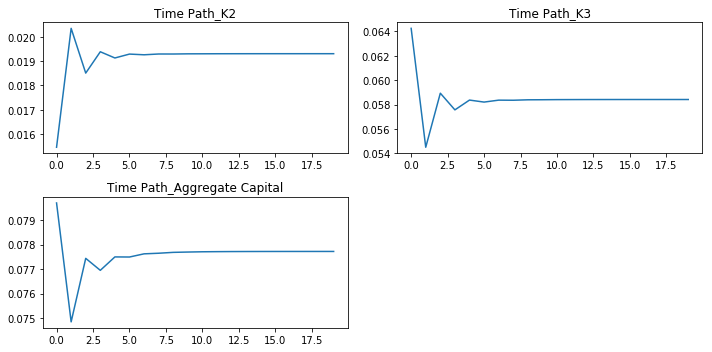

In [59]:

plt.subplot(221)
plt.plot(np.arange(0, 20), kmat[0, :])
plt.title('Time Path_K2')
plt.subplot(222)
plt.plot(np.arange(0, 20), kmat[1, :])
plt.title('Time Path_K3')
plt.subplot(223)
plt.plot(np.arange(0, 20), k_agg)
plt.title('Time Path_Aggregate Capital')
plt.tight_layout()
plt.show()


# exercise 11

In [61]:
rhoz = 0.9 ** 20
sigmaz = 0.02
e = np.random.normal(0, scale=sigmaz, size=(10000, 251))
z = np.zeros_like(e)
z[:, 0] = np.zeros(10000)
for i in range(1, 251):
    z[:, i] = rhoz * z[:, i - 1] + e[:, i]
k2 = np.zeros_like(e)
k3 = np.zeros_like(e)
k_agg = np.zeros_like(e)
c = np.zeros_like(e)
y = np.zeros_like(e)
I = np.zeros_like(e)


In [62]:
[A, B, C, D, F, G, H, J, K, L, M, W, T] = LinApp_Deriv(Model_olg, params, theta0, nx, ny, nz, logX = True)   
N = rhoz    
P,Q,U,R,S,V =LinApp_Solve(A,B,C,D,F,G,H,J,K,L,M,W,T,N,zbar,Sylv=0)


In [64]:
for i in range(1, 251):
    k2[:, i] = P[0, 0] * k2[:, i-1] + P[0, 1] * k3[:, i-1] + Q[0] * z[:, i]
    k3[:, i] = P[1, 0] * k2[:, i-1] + P[1, 1] * k3[:, i-1] + Q[0] * z[:, i]
k2 = k2bar * np.exp(k2)
k3 = k3bar * np.exp(k3)
k_agg = k2 + k3

w = get_w(k_agg, 2.2, z)
r = get_r(k_agg, 2.2, z)

for i in range(250):
    y[:, i] = k_agg[:, i] ** alpha * 2.2 ** (1 - alpha) * np.exp(z[:, i])
    I[:, i] = k_agg[:, i + 1] - (1 - delta) * k_agg[:, i]
    c[:, i] = w[:, i] - k2[:, i + 1] + w[:, i] + (1 + r[:, i]) * k2[:, i] - k3[:, i+1] + w[:, i] * 0.2 + (1 + r[:,i]) * k3[:, i]

y = y[:, 0:250]
I = I[:, 0:250]
c = c[:, 0:250]



In [65]:
ymean = y.mean(axis=0)
cmean = c.mean(axis=0)
Imean = I.mean(axis=0)
ymin = np.zeros(250)
ymax = np.zeros(250)
cmin = np.zeros(250)
cmax = np.zeros(250)
Imin = np.zeros(250)
Imax = np.zeros(250)
for i in range(250):
    ymin[i] = np.percentile(y[:, i], 5)
    ymax[i] = np.percentile(y[:, i], 95)
    cmin[i] = np.percentile(c[:, i], 5)
    cmax[i] = np.percentile(c[:, i], 95)
    Imin[i] = np.percentile(I[:, i], 5)
    Imax[i] = np.percentile(I[:, i], 95)

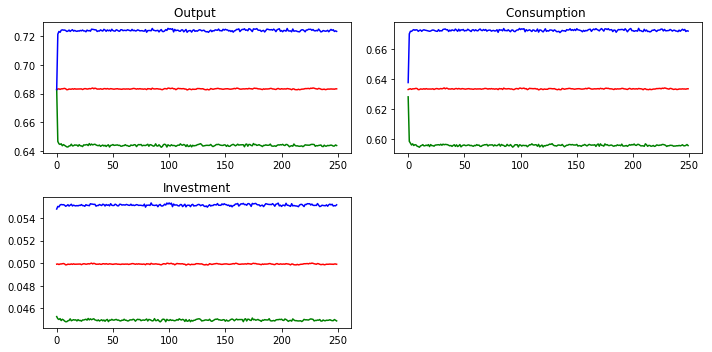

In [69]:
plt.subplot(221)
plt.plot(np.arange(0, 250), ymean[0: 250], c='r')
plt.plot(np.arange(0, 250), ymin, c ='g')
plt.plot(np.arange(0, 250), ymax, c ='b')
plt.title("Output ")
plt.subplot(222)
plt.plot(np.arange(0, 250), cmean[0: 250], c='r')
plt.plot(np.arange(0, 250), cmin, c ='g')
plt.plot(np.arange(0, 250), cmax, c ='b')
plt.title("Consumption ")
plt.subplot(223)
plt.plot(np.arange(0, 250), Imean[0: 250], c='r')
plt.plot(np.arange(0, 250), Imin, c ='g')
plt.plot(np.arange(0, 250), Imax, c ='b')
plt.title("Investment")
plt.tight_layout()
plt.show()
